## Read the data, clean the data from the test.csv and train.csv files

In [57]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Handling missing values by filling with median for numerical columns and mode for categorical columns
for column in train_data.columns:
    if train_data[column].dtype == 'object':
        train_data.fillna({column: train_data[column].mode()[0]}, inplace=True)
        test_data.fillna({column: test_data[column].mode()[0]}, inplace=True)
    else:
        train_data.fillna({column: train_data[column].median()}, inplace=True)
        test_data.fillna({column: test_data[column].median()}, inplace=True)

# Encoding categorical variables using LabelEncoder
label_encoders = {}
for column in train_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train_data[column] = le.fit_transform(train_data[column])
    test_data[column] = le.transform(test_data[column])
    label_encoders[column] = le

# Separating the Attrition column before scaling
y_train = train_data['Attrition']
train_data = train_data.drop(columns=['Attrition'])
y_test = test_data['Attrition']
test_data = test_data.drop(columns=['Attrition'])

# Standardizing numerical variables
scaler = StandardScaler()
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns

train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

# Adding the Attrition column back
train_data['Attrition'] = y_train
test_data['Attrition'] = y_test

# Display the first few rows of the cleaned datasets
print(train_data.head())
print(test_data.head())





   Employee ID       Age    Gender  Years at Company  Job Role  \
0    -1.339150 -0.626336  0.905758          0.288648 -1.441389   
1     1.279284  1.691627 -1.104048         -1.045173  0.597163   
2    -0.323906 -1.205827 -1.104048         -0.511645 -0.082354   
3     1.327381 -0.212414 -1.104048         -0.778409 -1.441389   
4     1.291831  1.443273  0.905758          2.244918 -1.441389   

   Monthly Income  Work-Life Balance  Job Satisfaction  Performance Rating  \
0       -0.888892          -1.567325          0.730794           -0.732548   
1       -0.821960           1.616473         -0.902332            2.417711   
2        0.398153           0.555207         -0.902332            2.417711   
3       -1.540084           0.555207         -0.902332            1.367624   
4       -1.153366          -0.506059          1.547357           -0.732548   

   Number of Promotions  ...  Number of Dependents  Job Level  Company Size  \
0              1.173308  ...             -1.059395   0.

## Build a Classification model to find out if an employee attrited or stayed

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Splitting the data into training and validation sets
X = train_data.drop(columns=['Employee ID', 'Attrition'])
y = train_data['Attrition']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predicting on the validation set
y_val_pred = rf_classifier.predict(X_val)


## Analyse any performance metrics for the classification model on the train and test data and explain the metrics in detail

In [59]:
# Evaluating the model
accuracy = accuracy_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred, target_names=['Stayed', 'Left'])

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Evaluating the model on the training data
y_train_pred = rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_class_report = classification_report(y_train, y_train_pred, target_names=['Stayed', 'Left'])

# Evaluating the model on the test data
X_test = test_data.drop(columns=['Employee ID', 'Attrition'])
y_test = test_data['Attrition']
y_test_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_class_report = classification_report(y_test, y_test_pred, target_names=['Stayed', 'Left'])

train_accuracy, train_class_report, test_accuracy, test_class_report

# from the results, the model is overfitting as the training accuracy is 1.0 while the test accuracy is 0.85

Accuracy: 0.7389261744966443
Confusion Matrix:
[[4137 1530]
 [1582 4671]]
Classification Report:
              precision    recall  f1-score   support

      Stayed       0.72      0.73      0.73      5667
        Left       0.75      0.75      0.75      6253

    accuracy                           0.74     11920
   macro avg       0.74      0.74      0.74     11920
weighted avg       0.74      0.74      0.74     11920



(1.0,
 '              precision    recall  f1-score   support\n\n      Stayed       1.00      1.00      1.00     22671\n        Left       1.00      1.00      1.00     25007\n\n    accuracy                           1.00     47678\n   macro avg       1.00      1.00      1.00     47678\nweighted avg       1.00      1.00      1.00     47678\n',
 0.7471140939597315,
 '              precision    recall  f1-score   support\n\n      Stayed       0.73      0.74      0.73      7032\n        Left       0.76      0.76      0.76      7868\n\n    accuracy                           0.75     14900\n   macro avg       0.75      0.75      0.75     14900\nweighted avg       0.75      0.75      0.75     14900\n')

## Including the AUC Metric

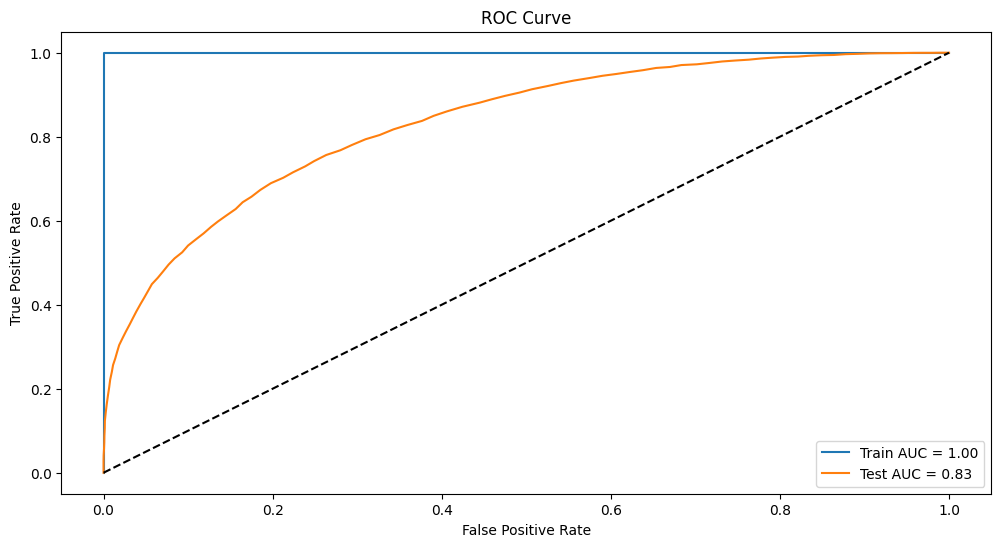

(1.0, 0.833009797827406)

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate AUC for the training data
y_train_prob = rf_classifier.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_prob)

# Calculate AUC for the test data
y_test_prob = rf_classifier.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC Curve for training and test data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(12, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {train_auc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

train_auc, test_auc
